In [1]:
import torch
import custom_model
import glm3_tokenizer

tokenizer = glm3_tokenizer.GLM3Tokenizer()
config = custom_model.CustomModelConfig(
            vocab_size=tokenizer.vocab_size(),
            padding_token_id=tokenizer.token_pad_id,
            max_position_embeddings=4096,
            hidden_size=704,
            num_heads=16,
            MLP_intermediate=5000,
            num_layers=28,
            attention_dropout=0.1,
            dtype=torch.bfloat16,
            training=True,
            linear_imp = torch.nn.Linear
        )

config.get_total_params()

embedding ratio: 0.1030929639406133
layers ratio: 0.7938124810060924
  * attn size ratio: 0.1254560526721942
  * MLP ratio: 0.6682673260237617
lm_head ratio: 0.1030929639406133
total:442457664 (~442M)


442457664

In [2]:
import torch
import pretrain
from friendly_num import friendly_num

trainer = pretrain.Trainer()

print("token_consumed:", friendly_num(trainer.token_consumed))

tokenizer = trainer.tokenizer
model = trainer.model
model.requires_grad_ = False

embedding ratio: 0.07983494067795566
layers ratio: 0.8403288864902961
  * attn size ratio: 0.10093803868223616
  * MLP ratio: 0.7392922755046594
lm_head ratio: 0.07983494067795566
total:415532544 (~415M)
415532544
checkpoints found! resume!
token_consumed: 491.67M


In [3]:
def test_greedy_search_generate(input_text):
    encoded = tokenizer.encode(input_text)
    input_ids = encoded.input_ids
    attn_mask = encoded.attention_mask

    start_seq_length = len(input_ids[0])

    generate_length = 100
    final_length = start_seq_length + generate_length

    input_ids_tensor = torch.zeros((1, final_length), dtype=tokenizer.dtype).to('cuda')
    attn_mask_tensor = torch.zeros((1, final_length), dtype=tokenizer.dtype).to('cuda')

    input_ids_tensor[0][:start_seq_length] = input_ids[0]
    attn_mask_tensor[0][:start_seq_length] = attn_mask[0]

    index = start_seq_length - 1

    while index < final_length - 1:
        logits = model.forward(input_ids_tensor, attn_mask_tensor)
        maxed = model.aggressive_decode(logits)
        input_ids_tensor[0][index + 1] = maxed[0][index]
        attn_mask_tensor[0][index + 1] = 1
        index += 1

    print("test input:", input_text)
    print("test out:", tokenizer.decode(input_ids_tensor))

test_inputs = [
    "中兴手机",
    "外交部网站22日发布",
    "基因组信息在生命科学研究中具有重要价值"
]
for text in test_inputs:
    test_greedy_search_generate(text)

test input: 中兴手机
test out: ['中兴手机：3G手机将成3G手机\n\u3000\u3000新浪科技讯 10月11日消息，中兴通讯董事长兼CEO中兴通讯董事长兼CEO中兴通讯董事长兼CEO中兴通讯董事长兼CEO中兴通讯董事长兼CEO柳传志表示，中兴通讯将推出3G手机，并计划在未来3年内推出3G手机。\n\u3000\u3000中兴通讯董事长兼CEO柳传志表示，中兴通讯将推出3G手机，并计划在未来3年内推出3G']
test input: 外交部网站22日发布
test out: ['外交部网站22日发布 外交部：中国将加强外交\n\u3000\u3000新华网北京12月10日电(记者 郝亚琳)外交部发言人马朝旭10日在北京举行例行记者会，就中国外交政策和外交政策等问题回答记者提问。\n\u3000\u3000马朝旭说，中国将一如既往地支持中国，支持中国发展。中国将一如既往地支持中国，支持中国发展。\n\u3000\u3000马朝旭说，中国将一如既往地支持中国发展，支持中国发展。']
test input: 基因组信息在生命科学研究中具有重要价值
test out: ['基因组信息在生命科学研究中具有重要价值\n\u3000\u3000新浪科技讯 北京时间10月10日消息，据国外媒体报道，科学家发现，在生命科学领域，人类在生命科学领域所具有的广泛价值是存在的。\n\u3000\u30001. 人类在生命科学领域所具有的广泛价值\n\u3000\u3000人类在生命科学领域所具有的广泛价值是存在的。人类在生命科学领域所具有的广泛价值是存在的。人类在生命科学领域所具有的广泛价值是存在的。\n\u3000']


In [4]:
def test_beam_search_generate(input_text, generate_length, num_beams):
    encoded = tokenizer.encode(input_text)
    input_ids = encoded.input_ids
    attn_mask = encoded.attention_mask

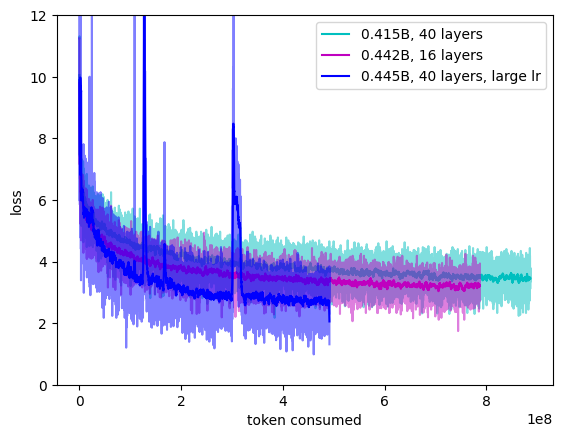

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import os
import json
import torch

def padded_avg(a: torch.Tensor, window_size: int):
    a = torch.vstack([a])
    assert window_size % 2 == 1
    bz = a.shape[0]
    pad_size = int(window_size // 2)
    start_pad = torch.ones((bz, pad_size)) * a[:, :1]
    end_pad = torch.ones((bz, pad_size)) * a[:, -1:]
    concat = torch.concat((start_pad, a, end_pad), dim=-1)
    return torch.nn.functional.avg_pool1d(concat, kernel_size=window_size, stride=1, padding=0)[0]

def get_training_log(saves_dir):
    checkpoints = list(map(lambda x: x.name, os.scandir(saves_dir)))
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[1]), reverse=False)

    log_entries = []

    for dir in checkpoints:
        log_path = os.path.join(saves_dir, dir, "logs.json")
        with open(log_path) as file:
            file_entries = json.load(file)
        log_entries += file_entries

    losses = list(map(lambda x: x["loss"], log_entries))
    token_comsumed = [x["token_consumed"] for x in log_entries]
    return torch.tensor(token_comsumed), torch.tensor(losses)

alpha = 0.5
window_size = 41

# colors = list(matplotlib.colormaps['Set1'].colors[:])
colors = ['c', 'r', 'y', 'b', 'm', 'c']

def plot_training_history(label, path):
    color = colors.pop()
    token_comsumed, losses = get_training_log(path)
    plt.plot(token_comsumed, losses, alpha=alpha, color=color)
    plt.plot(token_comsumed, padded_avg(losses, window_size), label=label, alpha=1.0, color=color)


plot_training_history("0.415B, 40 layers", "./saves_deeper")
plot_training_history("0.442B, 16 layers", "./saves_shallow")
plot_training_history("0.445B, 40 layers, large lr", "./saves")
plt.legend()
plt.xlabel("token consumed")
plt.ylabel("loss")
plt.ylim(0, 12)
plt.show()
